## Семинар 2 "Распознавание рукописных цифр"

ФИО: Роор Даниил Дмитриевич

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [44]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import sys
from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
from IPython.display import clear_output
%matplotlib inline

In [52]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [53]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

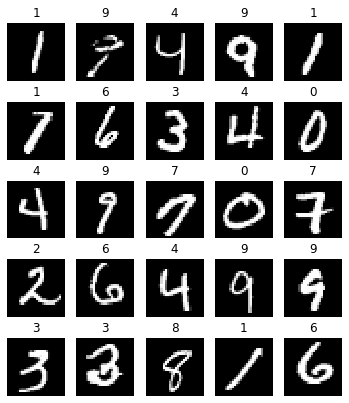

In [54]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [55]:
def train(network, epochs, learning_rate, plot=True,
          verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [56]:
network = NeuralNetwork([
    Linear(784, 100),
    Sigmoid(), # 28 * 28
    Linear(100, 100),
    Sigmoid(),
    Linear(100, 10)
])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.302/0.295	Accuracy: 0.921/0.922

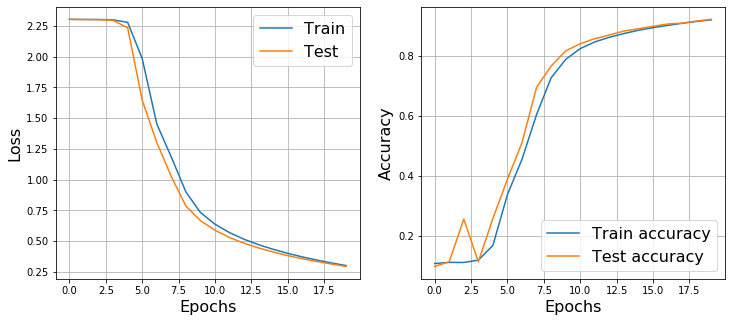

In [57]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 20, 0.01)

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [10]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.X > 0) * dLdy

    def step(self, learning_rate):
        pass

In [11]:
class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''
    
    def __init__(self, a = 1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.036/0.077	Accuracy: 0.991/0.977

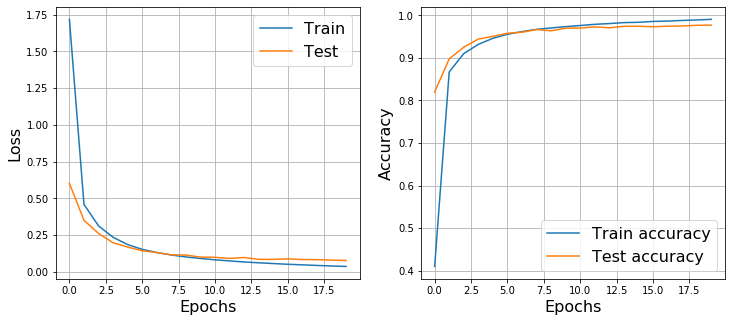

In [12]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, 20, 0.01, plot=True, verbose=True)

Epoch 19... (Train/Test) NLL: 0.049/0.080	Accuracy: 0.986/0.976

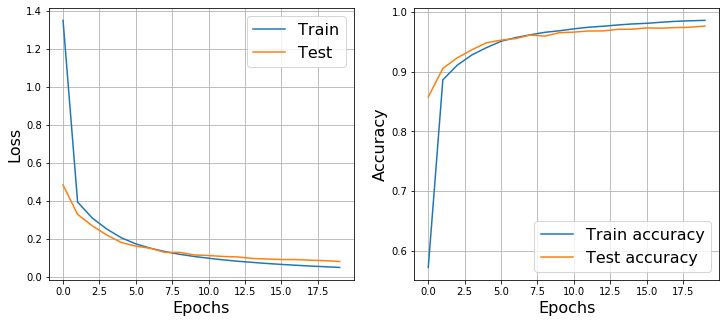

In [13]:
network = NeuralNetwork([Linear(784, 100), ELU(),
               Linear(100, 100), ELU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 20, 0.01, plot=True, verbose=True)

### HW1 (1 балл): Реализовать Tanh

In [26]:
class TanH:
    '''
    TanH(x) = ( e^x - e^(-x) ) / ( e^x + e^(-x) )
    '''
    
    def __tanh(self, X):
        return ( np.exp(X) - np.exp(-X) ) / ( np.exp(X) + np.exp(-X) )
    
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return self.__tanh(X)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        dydX = 1 - self.__tanh(self.X) ** 2
        return dLdy*dydX

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.030/0.077	Accuracy: 0.994/0.975

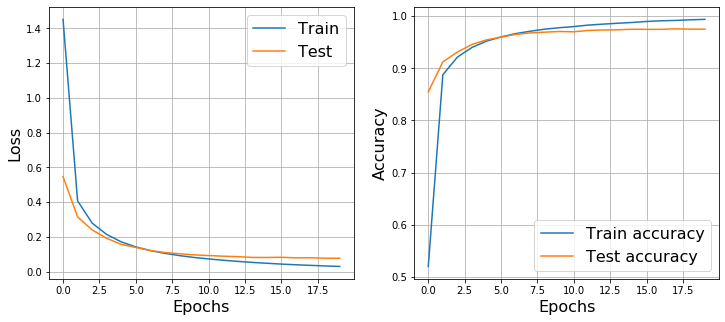

In [27]:
network = NeuralNetwork([Linear(784, 100), TanH(),
                         Linear(100, 100), TanH(),
                         Linear(100, 10)])
loss = NLLLoss()
tr_t, ts_t, tr_ac_t, ts_ac_t = train(network, 20, 0.01, plot=True, verbose=True)

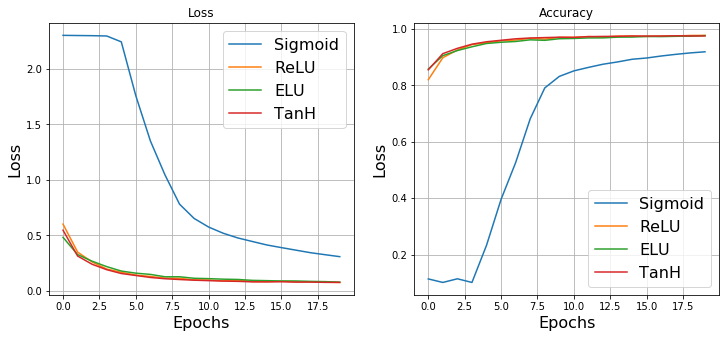

In [28]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.plot(ts_t, label='TanH')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.plot(ts_ac_t, label='TanH')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### Часть 3: Анализ ошибок

In [29]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = network.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

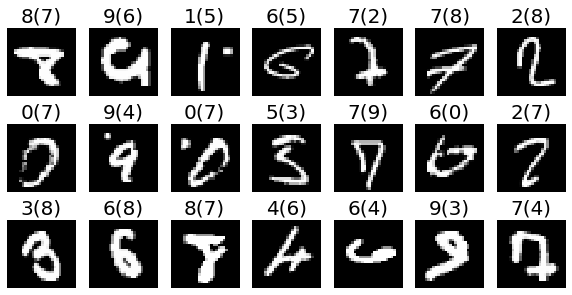

In [30]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

In [67]:
def train(network, epochs, learning_rate, train_loader, test_loader):
    
    loss = NLLLoss()
    train_loss_epochs = []
    test_loss_epochs  = []
    train_accuracy_epochs = []
    test_accuracy_epochs  = []
    
    try:
        for epoch in range(epochs):
            losses     = []
            accuracies = []
            
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append( (np.argmax(prediction, 1) == y ).mean())
                
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            
            losses     = []
            accuracies = []    
            
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append( (np.argmax(prediction, 1) == y).mean() )
                
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, test_loss_epochs, train_accuracy_epochs, test_accuracy_epochs

In [68]:
def applyTransform(new_transform = None):
    transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
    
    train_dataset = MNIST('.', train = True,  transform = transform)
    test_dataset  = MNIST('.', train = False, transform = transform)
    
    if new_transform:
        new_train_dataset = MNIST('.', train = True, download = True, transform = new_transform)
        train_dataset = train_dataset + new_train_dataset

    train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
    test_loader  = DataLoader(test_dataset,  batch_size = 32, shuffle = True)
    return train_loader, test_loader

##### Повороты (-15, 15)

In [69]:
def Rotate(activation):
    transform = transforms.Compose([
                        transforms.RandomAffine(15),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                            ])

    tr_loader, ts_loader = applyTransform(transform)
    network = NeuralNetwork([
        Linear(784, 100), activation,
        Linear(100, 100), activation,
        Linear(100, 10)
        ])

    return train(network, 10, 0.01, tr_loader, ts_loader)

##### Случайные сдвиги

In [70]:
def Shift(activation):
    transform = transforms.Compose([
                            transforms.RandomAffine(0, (0.1, 0.1)),
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,)),
                        ])
    tr_loader, ts_loader = applyTransform(transform)
    network = NeuralNetwork([
        Linear(784, 100), activation,
        Linear(100, 100), activation,
        Linear(100, 10)
    ])

    return train(network, 10, 0.01, tr_loader, ts_loader)

##### Добавление шума

In [71]:
def Noise(activation):

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x : x + torch.randn_like(x)),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    tr_loader, ts_loader = applyTransform(transform)
    network = NeuralNetwork([
        Linear(784, 100), activation,
        Linear(100, 100), activation,
        Linear(100, 10)
    ])
    return train(network, 10, 0.01, tr_loader, ts_loader)

##### Всё сразу

In [72]:
def All(activation):
    transform = transforms.Compose([
        transforms.RandomAffine(15, (0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x : x + torch.randn_like(x)),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    tr_loader, ts_loader = applyTransform(transform)
    network = NeuralNetwork([
        Linear(784, 100), activation,
        Linear(100, 100), activation,
        Linear(100, 10)
    ])
    return train(network, 10, 0.01, tr_loader, ts_loader)

### Сигмоида

In [101]:
sigm_tr_rot, sigm_ts_rot, sigm_tr_ac_rot, sigm_ts_ac_rot = Rotate(Sigmoid())

In [102]:
sigm_tr_sh, sigm_ts_sh, sigm_tr_ac_sh, sigm_ts_ac_sh = Shift(Sigmoid())

In [103]:
sigm_tr_n, sigm_ts_n, sigm_tr_ac_n, sigm_ts_ac_n = Noise(Sigmoid())

In [104]:
sigm_tr_all, sigm_ts_all, sigm_tr_ac_all, sigm_ts_ac_all = All(Sigmoid())

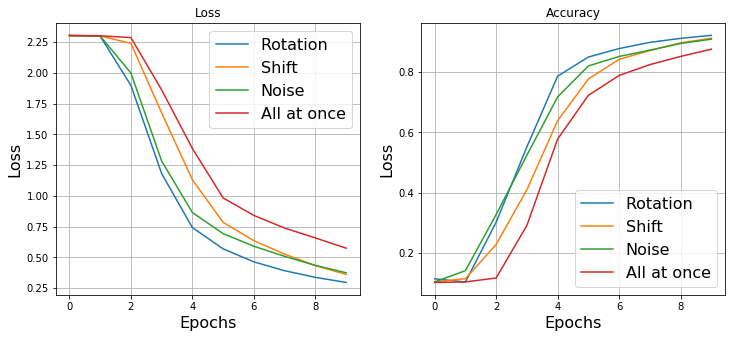

In [51]:
plt.figure(figsize = (12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(sigm_ts_rot, label = 'Rotation')
plt.plot(sigm_ts_sh,  label = 'Shift')
plt.plot(sigm_ts_n,   label = 'Noise')
plt.plot(sigm_ts_all, label = 'All at once')
plt.xlabel('Epochs', fontsize = 16)
plt.ylabel('Loss',   fontsize = 16)
plt.legend(loc = 0,  fontsize = 16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(sigm_ts_ac_rot, label = 'Rotation')
plt.plot(sigm_ts_ac_sh,  label = 'Shift')
plt.plot(sigm_ts_ac_n,   label = 'Noise')
plt.plot(sigm_ts_ac_all, label = 'All at once')
plt.xlabel('Epochs', fontsize = 16)
plt.ylabel('Loss',   fontsize = 16)
plt.legend(loc = 0,  fontsize = 16)
plt.grid()
plt.show()

In [105]:
print('Train loss without augmentation: {}'.format(tr_s[-1]))
print('Test  loss without augmentation: {}'.format(ts_s[-1]))

print('\n\n####################################\n\n')

print('Train loss with rotation: {}'.format(sigm_tr_rot[-1]))
print('Test  loss with rotation: {}'.format(sigm_ts_rot[-1]))

print('\n\n####################################\n\n')

print('Train loss with rotation: {}'.format(sigm_tr_rot[-1]))
print('Test  loss with rotation: {}'.format(sigm_ts_rot[-1]))

print('\n\n####################################\n\n')

print('Train loss with random shift: {}'.format(sigm_tr_sh[-1]))
print('Test  loss with random shift: {}'.format(sigm_ts_sh[-1]))

print('\n\n####################################\n\n')

print('Train loss with noise: {}'.format(sigm_tr_n[-1]))
print('Test  loss with noise: {}'.format(sigm_ts_n[-1]))

print('\n\n####################################\n\n')

print('Train loss with all augmentations: {}'.format(sigm_tr_all[-1]))
print('Test  loss with all augmentations: {}'.format(sigm_ts_all[-1]))

print('\n\n####################################\n\n')

print('Train accuracy without augmentation: {}'.format(tr_ac_s[-1]))
print('Test  accuracy without augmentation: {}'.format(ts_ac_s[-1]))

print('\n\n####################################\n\n')

print('Train accuracy with rotation: {}'.format(sigm_tr_ac_rot[-1]))
print('Test  accuracy with rotation: {}'.format(sigm_ts_ac_rot[-1]))

print('\n\n####################################\n\n')

print('Train accuracy with random shift: {}'.format(sigm_tr_ac_sh[-1]))
print('Test  accuracy with random shift: {}'.format(sigm_ts_ac_sh[-1]))

print('\n\n####################################\n\n')

print('Train accuracy with noise: {}'.format(sigm_tr_ac_n[-1]))
print('Test  accuracy with noise: {}'.format(sigm_ts_ac_n[-1]))

print('\n\n####################################\n\n')

print('Train accuracy with all augmentations: {}'.format(sigm_tr_ac_all[-1]))
print('Test  accuracy with all augmentations: {}'.format(sigm_ts_ac_all[-1]))

Train loss without augmentation: 0.3017823035358883
Test  loss without augmentation: 0.2946301555393527


####################################


Mean train loss with rotation: 0.5647804707157341
Mean test  loss with rotation: 0.49337559297472133


####################################


Train loss with rotation: 0.5647804707157341
Test  loss with rotation: 0.49337559297472133


####################################


Train loss with random shift: 0.9923621662763888
Test  loss with random shift: 0.675487432628959


####################################


Train loss with noise: 0.8882581846040021
Test  loss with noise: 0.5893932329561843


####################################


Train loss with all augmentations: 1.3824743035731277
Test  loss with all augmentations: 0.8684314486018632


####################################


Train accuracy without augmentation: 0.9206
Test  accuracy without augmentation: 0.9224241214057508


####################################


Train accuracy with rotation

### ELU

In [75]:
elu_tr_rot, elu_ts_rot, elu_tr_ac_rot, elu_ts_ac_rot = Rotate(ELU())

In [76]:
elu_tr_sh, elu_ts_sh, elu_tr_ac_sh, elu_ts_ac_sh = Shift(ELU())

In [77]:
elu_tr_n, elu_ts_n, elu_tr_ac_n, elu_ts_ac_n = Noise(ELU())

In [78]:
elu_tr_all, elu_ts_all, elu_tr_ac_all, elu_ts_ac_all = All(ELU())

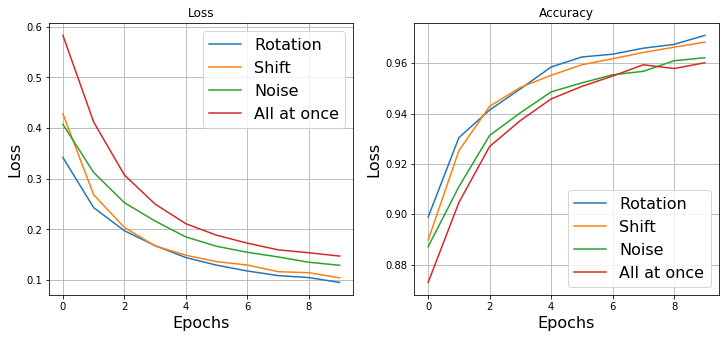

In [83]:
plt.figure(figsize = (12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(elu_ts_rot, label = 'Rotation')
plt.plot(elu_ts_sh,  label = 'Shift')
plt.plot(elu_ts_n,   label = 'Noise')
plt.plot(elu_ts_all, label = 'All at once')
plt.xlabel('Epochs', fontsize = 16)
plt.ylabel('Loss',   fontsize = 16)
plt.legend(loc = 0,  fontsize = 16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(elu_ts_ac_rot, label = 'Rotation')
plt.plot(elu_ts_ac_sh,  label = 'Shift')
plt.plot(elu_ts_ac_n,   label = 'Noise')
plt.plot(elu_ts_ac_all, label = 'All at once')
plt.xlabel('Epochs', fontsize = 16)
plt.ylabel('Loss',   fontsize = 16)
plt.legend(loc = 0,  fontsize = 16)
plt.grid()
plt.show()

In [109]:
print('Train loss without augmentation: {}'.format(tr_e[-1]))
print('Test  loss without augmentation: {}'.format(ts_e[-1]))

print('\n\n####################################\n\n')

print('Train loss with rotation: {}'.format(elu_tr_rot[-1]))
print('Test  loss with rotation: {}'.format(elu_ts_rot[-1]))

print('\n\n####################################\n\n')

print('Train loss with random shift: {}'.format(elu_tr_sh[-1]))
print('Test  loss with random shift: {}'.format(elu_ts_sh[-1]))

print('\n\n####################################\n\n')

print('Train loss with noise: {}'.format(elu_tr_n[-1]))
print('Test  loss with noise: {}'.format(elu_ts_n[-1]))

print('\n\n####################################\n\n')

print('Train loss with all augmentations: {}'.format(elu_tr_all[-1]))
print('Test  loss with all augmentations: {}'.format(elu_ts_all[-1]))

print('\n\n####################################\n\n')

print('Train accuracy without augmentation: {}'.format(tr_ac_e[-1]))
print('Test  accuracy without augmentation: {}'.format(ts_ac_e[-1]))

print('\n\n####################################\n\n')

print('Train accuracy with rotation: {}'.format(elu_tr_ac_rot[-1]))
print('Test  accuracy with rotation: {}'.format(elu_ts_ac_rot[-1]))

print('\n\n####################################\n\n')

print('Train accuracy with random shift: {}'.format(elu_tr_ac_sh[-1]))
print('Test  accuracy with random shift: {}'.format(elu_ts_ac_sh[-1]))

print('\n\n####################################\n\n')

print('Train accuracy with noise: {}'.format(elu_tr_ac_n[-1]))
print('Test  accuracy with noise: {}'.format(elu_ts_ac_n[-1]))

print('\n\n####################################\n\n')

print('Train accuracy with all augmentations: {}'.format(elu_tr_ac_all[-1]))
print('Test  accuracy with all augmentations: {}'.format(elu_ts_ac_all[-1]))

Train loss without augmentation: 0.048557008046230345
Test  loss without augmentation: 0.07976944904067275


####################################


Train loss with rotation: 0.11014640518760842
Test  loss with rotation: 0.09510928773506032


####################################


Train loss with random shift: 0.16250219758637208
Test  loss with random shift: 0.10416572832396466


####################################


Train loss with noise: 0.35961899075941633
Test  loss with noise: 0.15294405846980358


####################################


Train loss with all augmentations: 0.6504752994892223
Test  loss with all augmentations: 0.14717086949743477


####################################


Train accuracy without augmentation: 0.98585
Test  accuracy without augmentation: 0.9762380191693291


####################################


Train accuracy with rotation: 0.9666083333333333
Test  accuracy with rotation: 0.9710463258785943


####################################


Train accuracy with 

### ReLU

In [85]:
relu_tr_rot, relu_ts_rot, relu_tr_ac_rot, relu_ts_ac_rot = Rotate(ReLU())

In [86]:
relu_tr_sh, relu_ts_sh, relu_tr_ac_sh, relu_ts_ac_sh = Shift(ReLU())

In [87]:
relu_tr_n, relu_ts_n, relu_tr_ac_n, relu_ts_ac_n = Noise(ReLU())

In [88]:
relu_tr_all, relu_ts_all, relu_tr_ac_all, relu_ts_ac_all = All(ReLU())

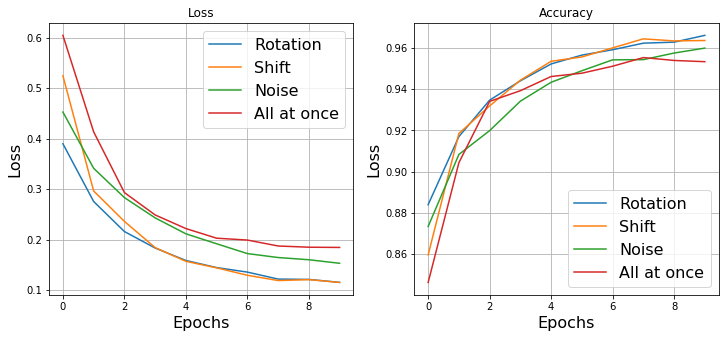

In [89]:
plt.figure(figsize = (12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(relu_ts_rot, label = 'Rotation')
plt.plot(relu_ts_sh,  label = 'Shift')
plt.plot(relu_ts_n,   label = 'Noise')
plt.plot(relu_ts_all, label = 'All at once')
plt.xlabel('Epochs', fontsize = 16)
plt.ylabel('Loss',   fontsize = 16)
plt.legend(loc = 0,  fontsize = 16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(relu_ts_ac_rot, label = 'Rotation')
plt.plot(relu_ts_ac_sh,  label = 'Shift')
plt.plot(relu_ts_ac_n,   label = 'Noise')
plt.plot(relu_ts_ac_all, label = 'All at once')
plt.xlabel('Epochs', fontsize = 16)
plt.ylabel('Loss',   fontsize = 16)
plt.legend(loc = 0,  fontsize = 16)
plt.grid()
plt.show()

In [107]:
print('Train loss without augmentation: {}'.format(tr_r[-1]))
print('Test  loss without augmentation: {}'.format(ts_r[-1]))

print('\n\n####################################\n\n')

print('Train loss with rotation: {}'.format(relu_tr_rot[-1]))
print('Test  loss with rotation: {}'.format(relu_ts_rot[-1]))

print('\n\n####################################\n\n')

print('Train loss with random shift: {}'.format(relu_tr_sh[-1]))
print('Test  loss with random shift: {}'.format(relu_ts_sh[-1]))

print('\n\n####################################\n\n')

print('Train loss with noise: {}'.format(relu_tr_n[-1]))
print('Test  loss with noise: {}'.format(relu_ts_n[-1]))

print('\n\n####################################\n\n')

print('Train loss with all augmentations: {}'.format(relu_tr_all[-1]))
print('Test  loss with all augmentations: {}'.format(relu_ts_all[-1]))

print('\n\n####################################\n\n')

print('Train accuracy without augmentation: {}'.format(tr_ac_r[-1]))
print('Test  accuracy without augmentation: {}'.format(ts_ac_r[-1]))

print('\n\n####################################\n\n')

print('Train accuracy with rotation: {}'.format(relu_tr_ac_rot[-1]))
print('Test  accuracy with rotation: {}'.format(relu_ts_ac_rot[-1]))

print('\n\n####################################\n\n')

print('Train accuracy with random shift: {}'.format(relu_tr_ac_sh[-1]))
print('Test  accuracy with random shift: {}'.format(relu_ts_ac_sh[-1]))

print('\n\n####################################\n\n')

print('Train accuracy with noise: {}'.format(relu_tr_ac_n[-1]))
print('Test  accuracy with noise: {}'.format(relu_ts_ac_n[-1]))

print('\n\n####################################\n\n')

print('Train accuracy with all augmentations: {}'.format(relu_tr_ac_all[-1]))
print('Test  accuracy with all augmentations: {}'.format(relu_ts_ac_all[-1]))

Train loss without augmentation: 0.036368742382761214
Test  loss without augmentation: 0.07689836902150775


####################################


Train loss with rotation: 0.12544255342334965
Test  loss with rotation: 0.1151420763304092


####################################


Train loss with random shift: 0.18297941070075316
Test  loss with random shift: 0.11494600130814557


####################################


Train loss with noise: 0.40328266424440395
Test  loss with noise: 0.15294405846980358


####################################


Train loss with all augmentations: 0.7216055148612849
Test  loss with all augmentations: 0.18434249583165035


####################################


Train accuracy without augmentation: 0.9906833333333334
Test  accuracy without augmentation: 0.9771365814696485


####################################


Train accuracy with rotation: 0.9623
Test  accuracy with rotation: 0.9661541533546326


####################################


Train accuracy with ra

### TanH

In [91]:
tanh_tr_rot, tanh_ts_rot, tanh_tr_ac_rot, tanh_ts_ac_rot = Rotate(TanH())

In [92]:
tanh_tr_sh, tanh_ts_sh, tanh_tr_ac_sh, tanh_ts_ac_sh = Shift(TanH())

In [93]:
tanh_tr_n, tanh_ts_n, tanh_tr_ac_n, tanh_ts_ac_n = Noise(TanH())

In [94]:
tanh_tr_all, tanh_ts_all, tanh_tr_ac_all, tanh_ts_ac_all = All(TanH())

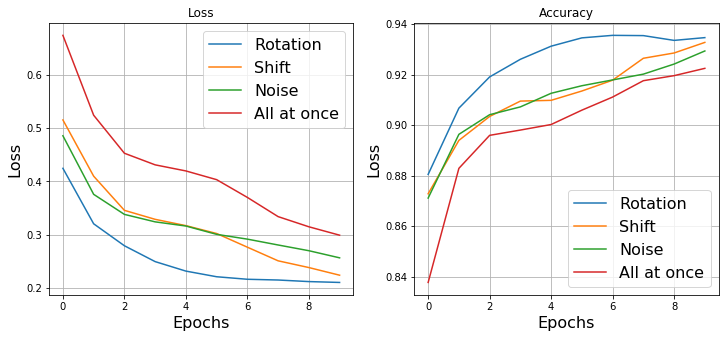

In [95]:
plt.figure(figsize = (12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(tanh_ts_rot, label = 'Rotation')
plt.plot(tanh_ts_sh,  label = 'Shift')
plt.plot(tanh_ts_n,   label = 'Noise')
plt.plot(tanh_ts_all, label = 'All at once')
plt.xlabel('Epochs', fontsize = 16)
plt.ylabel('Loss',   fontsize = 16)
plt.legend(loc = 0,  fontsize = 16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(tanh_ts_ac_rot, label = 'Rotation')
plt.plot(tanh_ts_ac_sh,  label = 'Shift')
plt.plot(tanh_ts_ac_n,   label = 'Noise')
plt.plot(tanh_ts_ac_all, label = 'All at once')
plt.xlabel('Epochs', fontsize = 16)
plt.ylabel('Loss',   fontsize = 16)
plt.legend(loc = 0,  fontsize = 16)
plt.grid()
plt.show()

In [108]:
print('Train loss without augmentation: {}'.format(tr_t[-1]))
print('Test  loss without augmentation: {}'.format(ts_t[-1]))

print('\n\n####################################\n\n')

print('Train loss with rotation: {}'.format(tanh_tr_rot[-1]))
print('Test  loss with rotation: {}'.format(tanh_ts_rot[-1]))

print('\n\n####################################\n\n')

print('Train loss with random shift: {}'.format(tanh_tr_sh[-1]))
print('Test  loss with random shift: {}'.format(tanh_ts_sh[-1]))

print('\n\n####################################\n\n')

print('Train loss with noise: {}'.format(tanh_tr_n[-1]))
print('Test  loss with noise: {}'.format(tanh_ts_n[-1]))

print('\n\n####################################\n\n')

print('Train loss with all augmentations: {}'.format(tanh_tr_all[-1]))
print('Test  loss with all augmentations: {}'.format(tanh_ts_all[-1]))

print('\n\n####################################\n\n')

print('Train accuracy without augmentation: {}'.format(tr_ac_t[-1]))
print('Test  accuracy without augmentation: {}'.format(ts_ac_t[-1]))

print('\n\n####################################\n\n')

print('Train accuracy with rotation: {}'.format(tanh_tr_ac_rot[-1]))
print('Test  accuracy with rotation: {}'.format(tanh_ts_ac_rot[-1]))

print('\n\n####################################\n\n')

print('Train accuracy with random shift: {}'.format(tanh_tr_ac_sh[-1]))
print('Test  accuracy with random shift: {}'.format(tanh_ts_ac_sh[-1]))

print('\n\n####################################\n\n')

print('Train accuracy with noise: {}'.format(tanh_tr_ac_n[-1]))
print('Test  accuracy with noise: {}'.format(tanh_ts_ac_n[-1]))

print('\n\n####################################\n\n')

print('Train accuracy with all augmentations: {}'.format(tanh_tr_ac_all[-1]))
print('Test  accuracy with all augmentations: {}'.format(tanh_ts_ac_all[-1]))

Train loss without augmentation: 0.030292554628332483
Test  loss without augmentation: 0.07733990972743626


####################################


Train loss with rotation: 0.2355569508363074
Test  loss with rotation: 0.21031407664858057


####################################


Train loss with random shift: 0.36563171465115346
Test  loss with random shift: 0.2239018200384595


####################################


Train loss with noise: 0.5318512427427144
Test  loss with noise: 0.25648656962978433


####################################


Train loss with all augmentations: 0.8726338344563549
Test  loss with all augmentations: 0.2989913638737697


####################################


Train accuracy without augmentation: 0.9937833333333334
Test  accuracy without augmentation: 0.9750399361022364


####################################


Train accuracy with rotation: 0.9284916666666667
Test  accuracy with rotation: 0.9347044728434505


####################################


Train accurac

### Часть 5: Выводы

Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

ReLU, ELU и TanH сходятся значительно быстрее Sigmoid и дают заметный качественный прирост точности.

Аугментации несущественно повлияли на скорость сходимости. Точность падает, причем на трейне заметно сильнее, чем на тесте